# Report of World Trade Graph

This report contains some summary statistics and graphs relating to the COMEXT+WTO dataset about import/export exchanges between countries. 
The steps that were done before the analysis are the following:
- combine I/E when regarding the same edge, with the mean;
- normalization by populationat each year (UN dataset), thus defining € pro capite as values;
- for every year, for every prod category, compute metrics graph-level and node-level, including the communities with the SBM;
- visual analysis of knwon scenarios.

## Code and functions

In [ ]:
import os, sys

colab = False
# #### COLAB ONLY CELL
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    # drive.mount('/content/gdrive',force_remount=True)
    os.chdir("/content/gdrive/MyDrive/COMEXT")
    !pip install -q -r world-trade-thesis/requirements.txt
    # !pwd
    sys.path.append('/content/gdrive/MyDrive/COMEXT/world-trade-thesis/src')
else:
    os.chdir("H:/My Drive/COMEXT")
    print(os.getcwd())
    sys.path.append('H:/My Drive/COMEXT/world-trade-thesis/src')

import pandas as pd
import networkx as nx
import numpy as np
import graph_analysis as g
from tqdm.notebook import tqdm, trange

# exec(open("world-trade-thesis/src/graph_analysis.py","r").read())

df_pop, eu_iso = g.load_population_df()

/h/My Drive/COMEXT
Functions loaded!


In [ ]:
def plot_bar_metr(metrics_df,country="IT",metr="density",log=False):
    ita_in = metrics_df[(metrics_df.country == country)&(metrics_df["prod"] != "TO")]
    # ita_in = metrics_df[(metrics_df.country == "IT")]
    ita_pivot = ita_in[["year","month","prod",metr]].reset_index(drop=True).pivot(index=["year","month"], columns=["prod"])
    if not log:
        ita_pivot.mean(axis=0).reset_index(level=0,drop=True).rename({i:i+" "+g.get_cat_name("full",i)[:30] for _,i in ita_pivot.columns},axis=0)\
                 .sort_values(ascending=False).iloc[:25].plot.bar(figsize=(20,8))
        plt.ylabel(metr)
    else:
        np.log10(ita_pivot.mean(axis=0)).reset_index(level=0,drop=True).rename({i:i+" "+g.get_cat_name("full",i)[:30] for _,i in ita_pivot.columns},axis=0)\
                 .sort_values(ascending=False).iloc[:25].plot.bar(figsize=(20,8))
        plt.ylabel("log "+metr)
    # plt.xticks(rotation=45, rotation_mode="anchor", position=(0.1,-0.11))
    plt.axhline(y=0,color="k",linewidth=0.5)
    if country in ["density","density_adj"]:
        plt.title("Mean "+ metr +" across time for "+country+", top 25 categories", fontsize=20)
    else:
        plt.title("Mean "+ metr +" across time, top 25 categories", fontsize=20)
    # plt.show()

In [ ]:
code = "06"
year = "2019"
category = g.get_cat_name("full",code)
print(category)

Crude petroleum and natural gas


In [ ]:
df_pop, eu_iso = g.load_population_df()
complete_metrics_df = pd.read_parquet("./data-samples/metrics/metrics_complete_V_2_sbm2.parquet")

In [ ]:
df_complete = g.load_filtered_data("wto", save=True, verbose=2, sorted=False, force_reload=True, types=g.full_types, columns=g.full_columns, group_by_prod_code=True, n_digits=2,
                             years=[int(year)], months=None, product="all", flow="all", trade_type="all",  declarant_iso="all", partner_iso="all")

loading wto: 

2019 ,	 Table loaded


## Threshold Analysis

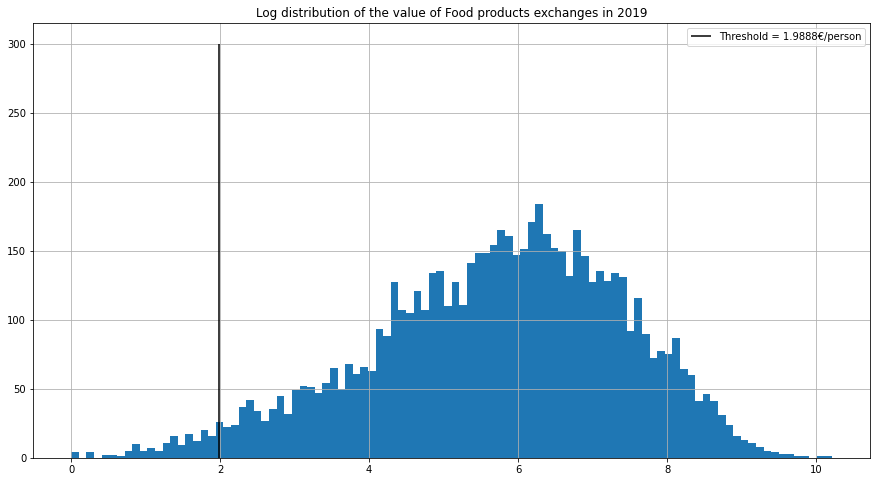

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(np.log10(df_complete.VALUE_IN_EUROS[(df_complete.VALUE_IN_EUROS > 0)&(df_complete.PRODUCT_CPA2_1 == "10")]),bins=100)
plt.title(f"Log distribution of the value of {category} exchanges in {year}")
plt.vlines(np.log10(97.45846753467485),0,300,label=f"Threshold = {np.log10(97.45846753467485):.4f}€/person")
plt.grid()
plt.legend()
plt.show()
# Why log-normal????

In [ ]:
thresholds = {str(y):{} for y in range(2001,2021)}
for y in trange(2001,2021):
    df_full, _ = g.load_filtered_data("complete", save=True, force_reload=False, verbose=False, sorted=False, columns=g.full_columns, types=g.full_types, group_by_prod_code=True, n_digits=2,
                                    years=[y], months=None, product="all", flow="all", declarant_iso="all", partner_iso="all", trade_type="all")
    for prod in tqdm(df_full.PRODUCT_CPA2_1.unique(),leave=False):
        df4g = df_full[df_full.PRODUCT_CPA2_1 == prod]
        df_full_scaled = g.extract_table_for_graph(df4g, y=str(y), flow="all", scale_by="population",pop_df=df_pop)
        df7 = df_full_scaled.sort_values("VALUE_IN_EUROS_SCALED",ascending=False).reset_index(drop=True)
        df7 = df7[df7.VALUE_IN_EUROS_RESCALED.cumsum() < 0.9999]
        thresholds[str(y)][prod] = df7.iloc[-1,-4]
# pd.DataFrame(thresholds).to_csv("data-samples/manual/complete_thresholds.csv")

## Analysis of graph metrics for an example category: Food products

#### Categories

In [ ]:
for i in range(100):
    print(f"{i:02d}",g.get_cat_name("full",f"{i:02d}"))

00 Unknown
01 Products of agriculture, hunting and related services
02 Products of forestry, logging and related services
03 Fish and other fishing products; aquaculture products; support services to fishing
04 Unknown
05 Coal and lignite
06 Crude petroleum and natural gas
07 Metal ores
08 Other mining and quarrying products
09 Mining support services
10 Food products
11 Beverages
12 Tobacco products
13 Textiles
14 Wearing apparel
15 Leather and related products
16 Wood and of products of wood and cork, except furniture; articles of straw and plaiting materials
17 Paper and paper products
18 Printing and reproduction services of recorded media
19 Coke and refined petroleum products
20 Chemicals and chemical products
21 Basic pharmaceutical products and pharmaceutical preparations
22 Rubber and plastic products
23 Other non-metallic mineral products
24 Basic metals
25 Fabricated metal products, except machinery and equipment
26 Computer, electronic and optical products
27 Electrical equ

### Mean Density across time

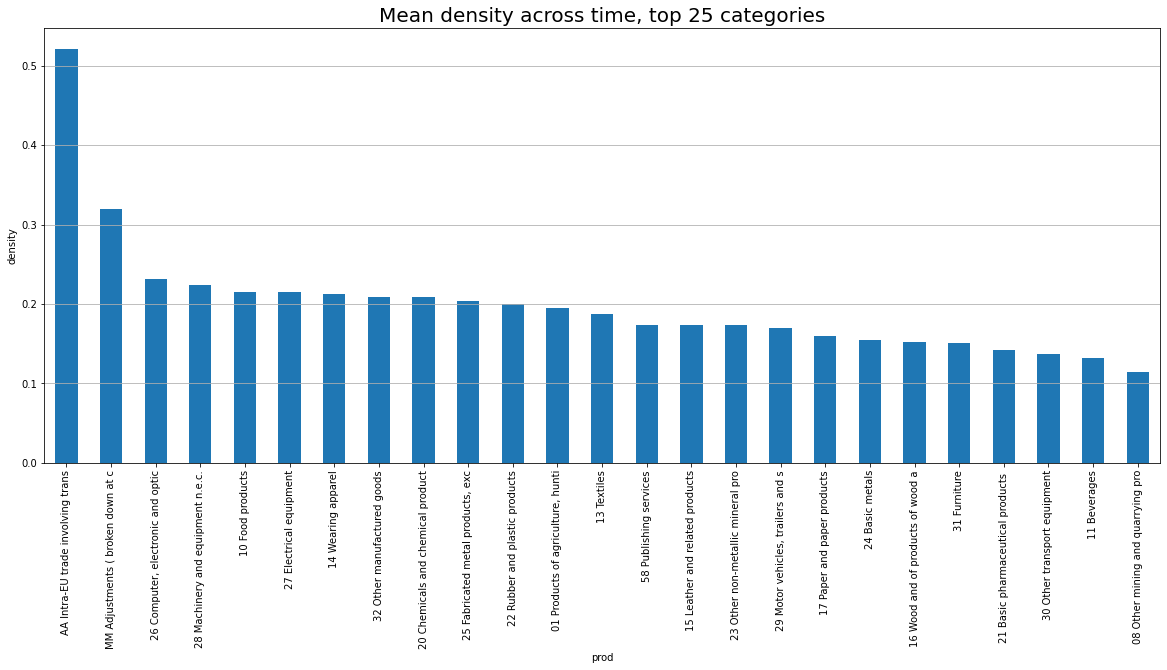

In [ ]:
plot_bar_metr(complete_metrics_df,metr="density",log=False)
plt.grid(axis="y")

### Network plots

In [ ]:
tab_nodes = pd.DataFrame(g.get_world_countries(df_pop, eu_iso, year)).set_index(0)

In [ ]:
# ["tab:blue" if tab_nodes.loc[c,1]["eu"] else "tab:red" for c in G.nodes()]

In [ ]:
df4g = df_complete[df_complete.PRODUCT_CPA2_1 == "10"].copy()
t4g = g.extract_table_for_graph(df4g, y=year, flow="all", scale_by='population', pop_df=df_pop)
coord, metrics, G = g.makeGraph(t4g, tab_nodes=tab_nodes, weight_flag=True, compute_layout=True, lay_dist=150, compute_metrics=False)
plt.figure(figsize=(20,15),dpi=200,facecolor="w")
edg_color = [G.get_edge_data(u,v)["weight"] for u,v in G.edges()]
m = max(edg_color)
edg_color = [(i/m)*256+30 for i in edg_color]
nx.draw_networkx(G, pos=coord, edge_color="orange", width=[i/60 for i in edg_color], font_color="white", font_size=10, node_size=300, node_color=["tab:blue" if tab_nodes.loc[c,1]["eu"] else "tab:red" for c in G.nodes()])
plt.title(f"Network of exchanges of {category} in {year}",fontsize=20)
plt.show()

KeyError: 1

<Figure size 4000x3000 with 0 Axes>

In [ ]:
sbm_2019_10 = complete_metrics_df[(complete_metrics_df.year == year)&(complete_metrics_df["prod"] == code)].set_index("country").sbm_block
sbm_2019_06 = complete_metrics_df[(complete_metrics_df.year == year)&(complete_metrics_df["prod"] == code)].set_index("country").sbm_block

In [ ]:
def intify(x):
    if "." in x:
        return int(x[:-2])
    else:
        return int(x)
sbm_2019_10 = sbm_2019_10.apply(intify)
sbm_2019_06 = sbm_2019_06.apply(intify)

In [ ]:
plt.figure(figsize=(20,15),dpi=200,facecolor="w")
nx.draw_networkx(G, pos=coord, edge_color="salmon", width=[i/60 for i in edg_color], font_color="white", font_size=10, node_size=300, cmap="tab20", node_color=[sbm_2019_06.loc[c] for c in G.nodes()])
plt.title(f"Network of exchanges of {category} in {year}",fontsize=20)
plt.show()

KeyError: 1

<Figure size 4000x3000 with 0 Axes>

# Category Historical Data

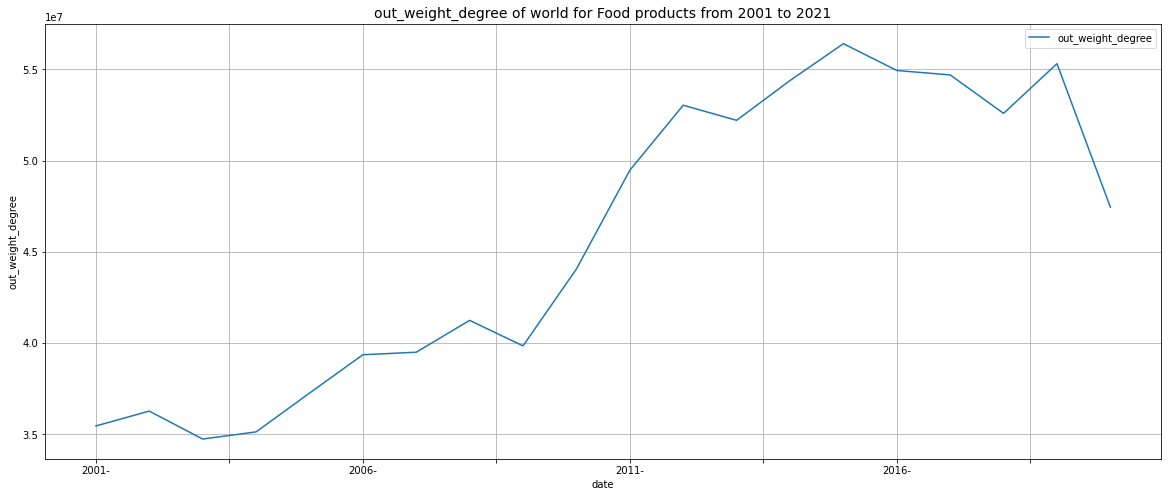

In [ ]:
g.plot_cat_ts(complete_metrics_df, metr="out_weight_degree", prod=code, moving_avg=None, country="world")
plt.grid()

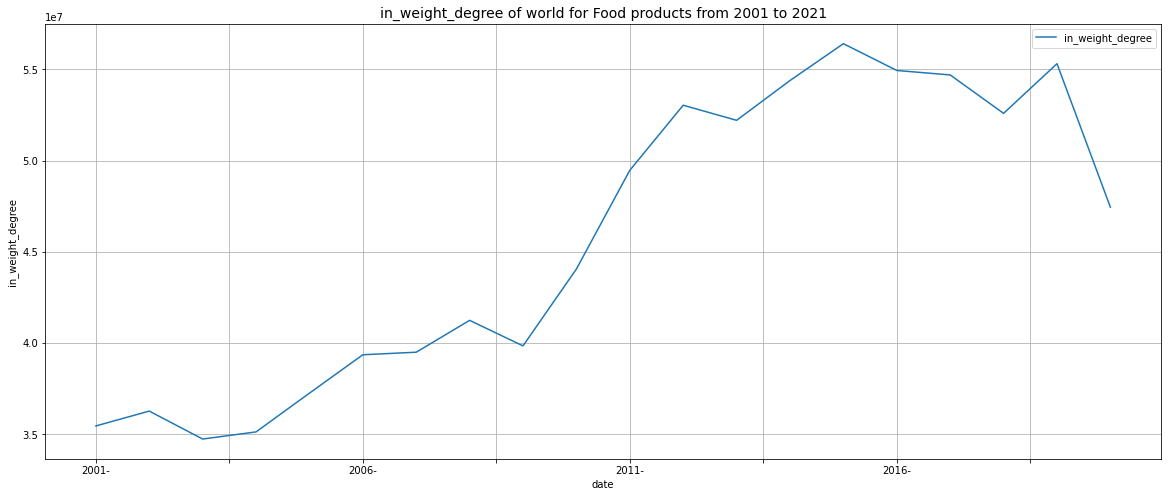

In [ ]:
g.plot_cat_ts(complete_metrics_df, metr="in_weight_degree", prod=code, moving_avg=None, country="world")
plt.grid()

In [ ]:
metrics_cat = complete_metrics_df[(complete_metrics_df["prod"] == code)&(complete_metrics_df.year == year)]
metrics_cat_avg = metrics_cat.groupby(["country"],as_index=False).mean().set_index("country")

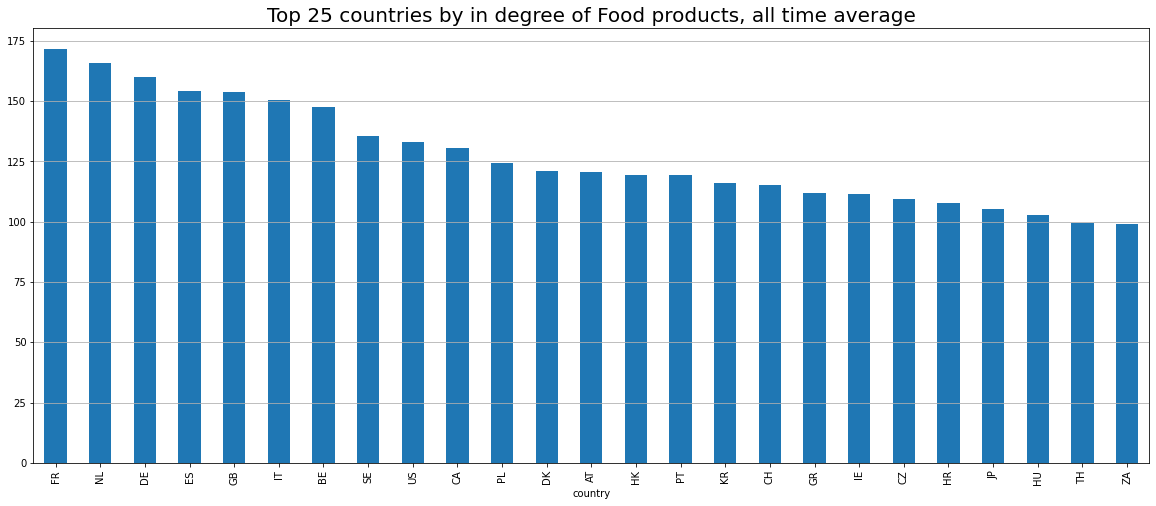

In [ ]:
metrics_cat_avg.in_degree.sort_values(ascending=False).iloc[:25].plot.bar(figsize=(20,8))
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.title(f"Top 25 countries by in degree of {category}, all time average",fontsize=20)
plt.show()

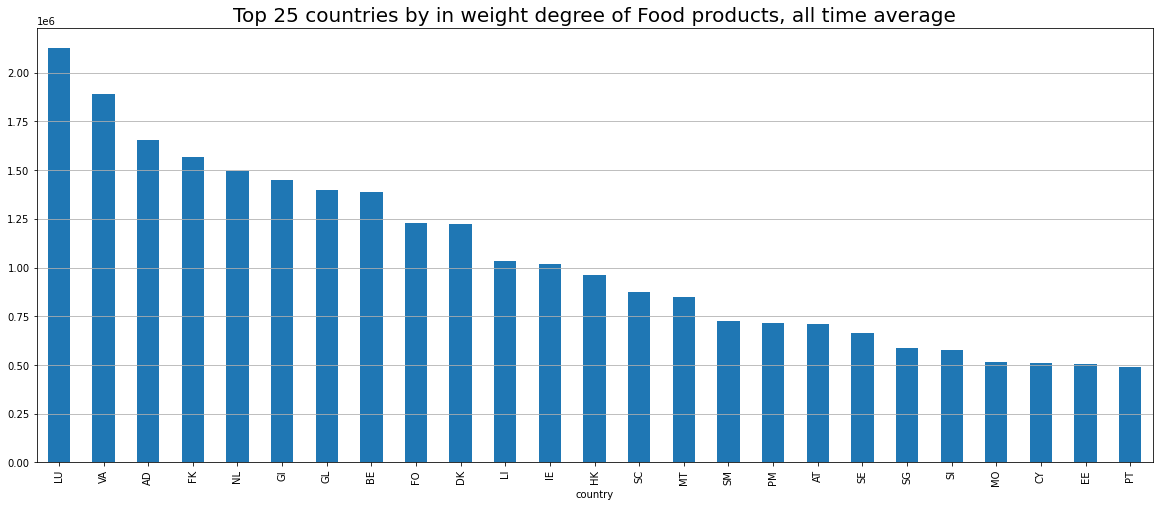

In [ ]:
metrics_cat_avg.in_weight_degree.sort_values(ascending=False).iloc[:25].plot.bar(figsize=(20,8))
plt.grid(axis="y")
plt.xticks(rotation=90)
plt.title(f"Top 25 countries by in weight degree of {category}, all time average",fontsize=20)
plt.show()

### Power law

In [ ]:
exec(open("world-trade-thesis/src/graph_analysis.py","r").read())

Functions loaded!


##### Degree

In [ ]:
metr_df = metrics_cat
metric = "in_weight_degree"

In [ ]:
y, x = np.histogram(metr_df[metric],bins=1000,density=True)
x = np.array([np.mean([x[i],x[i+1]]) for i in range(len(x)-1)])
print(len(x),len(y))
x = x[y > 0]
y = y[y > 0]
print(len(x),len(y))
x_log = np.log10(x)
y_log = np.log10(y)
results = powerlaw.Fit(metr_df[metric].to_numpy(),xmin=1,discrete=True)
print("Power law degree is:", results.power_law.alpha)
print("Power law xmin is:", results.power_law.xmin)

1000 1000
110 110
Power law degree is: 1.0886176784043498
Power law xmin is: 1.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [ ]:
metr_df[metric].to_numpy().min(), metr_df[metric].to_numpy().max()

(1, 362)

Power law degree is: 1.2103393384646304
Power law xmin is: 1.0


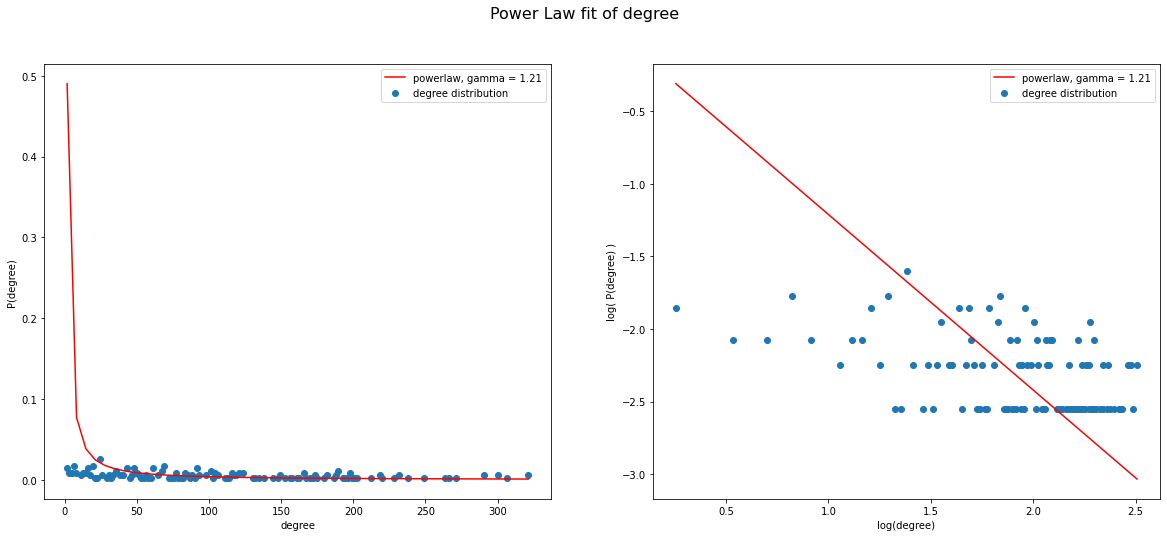

In [ ]:
plot_power_law(metrics_cat, "degree", discrete=True, pw_plot=False, xmin=1)

##### In degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.247046479027426
Power law xmin is: 1.0


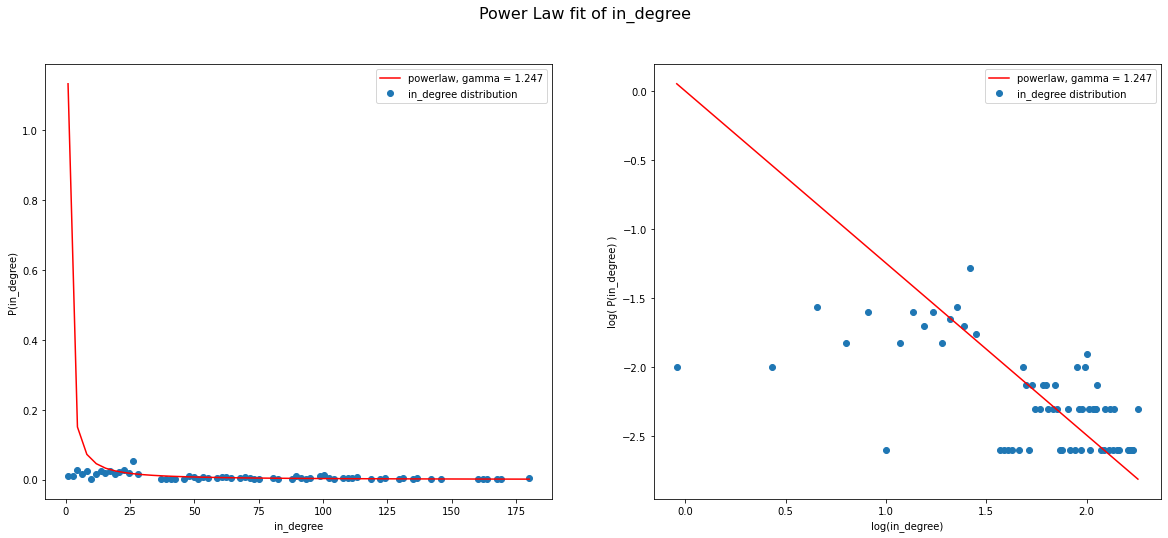

In [ ]:
plot_power_law(metrics_cat,"in_degree",discrete=True,xmin=1)

##### In weight degree

<AxesSubplot:>

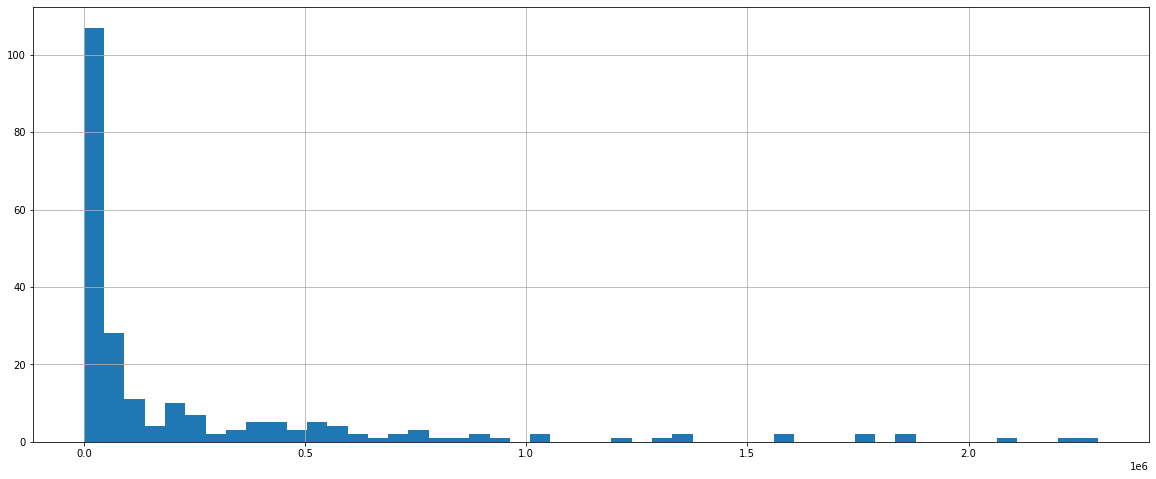

In [ ]:
metrics_cat["in_weight_degree"].sort_values().hist(figsize=(20,8),bins=50)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.0944172679576136
Power law xmin is: 1.0


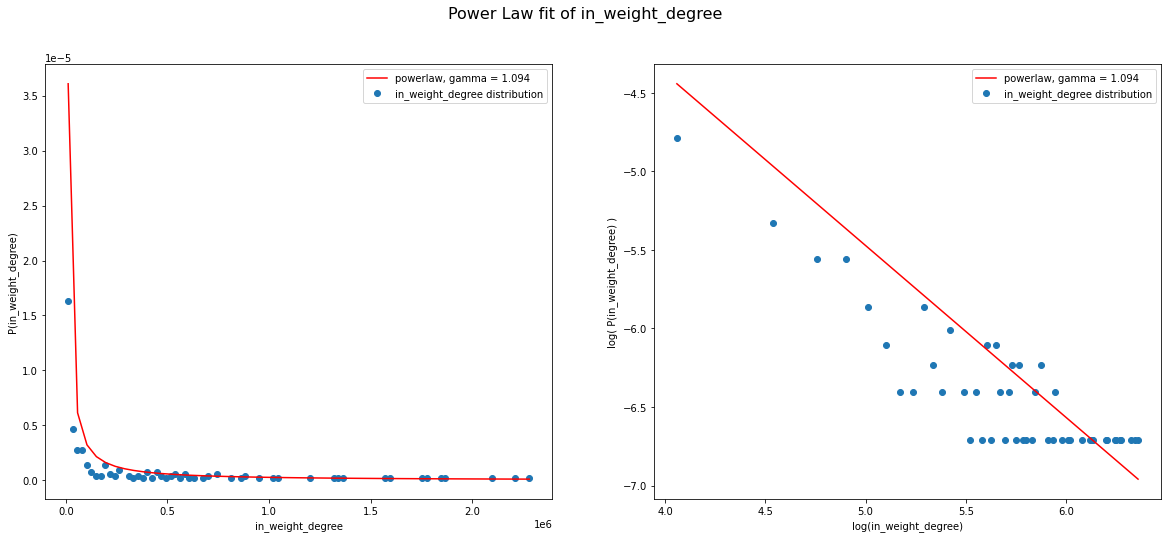

In [ ]:
plot_power_law(metrics_cat,"in_weight_degree",discrete=False,xmin=1,bins=100)

##### Out degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.2947525298360179


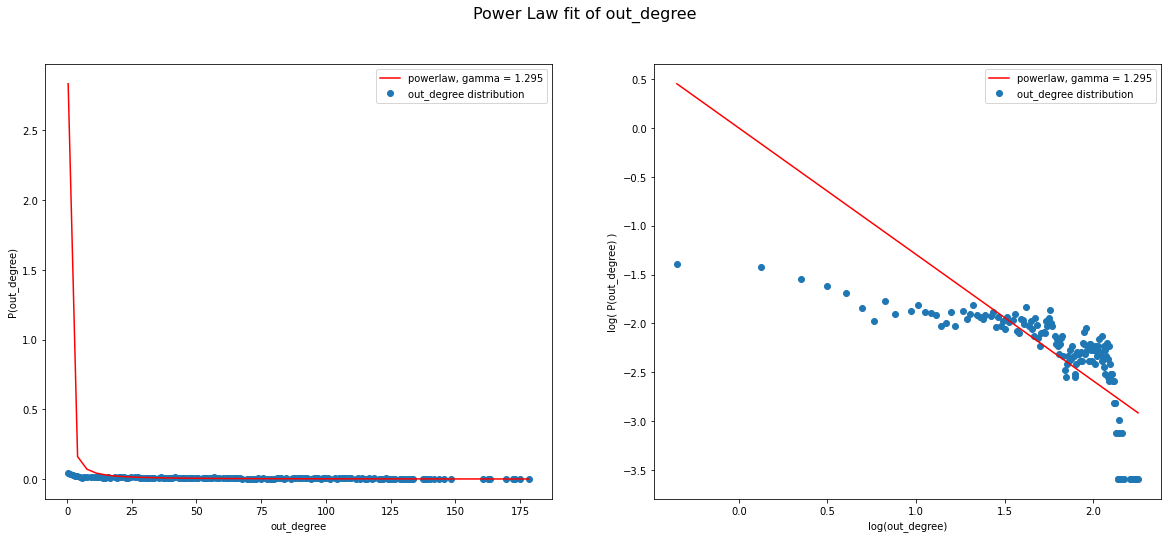

In [ ]:
g.plot_power_law(metrics_cat,"out_degree")

#### Out weight degree

Values less than or equal to 0 in data. Throwing out 0 or negative values


Power law degree is: 1.1125434094853013


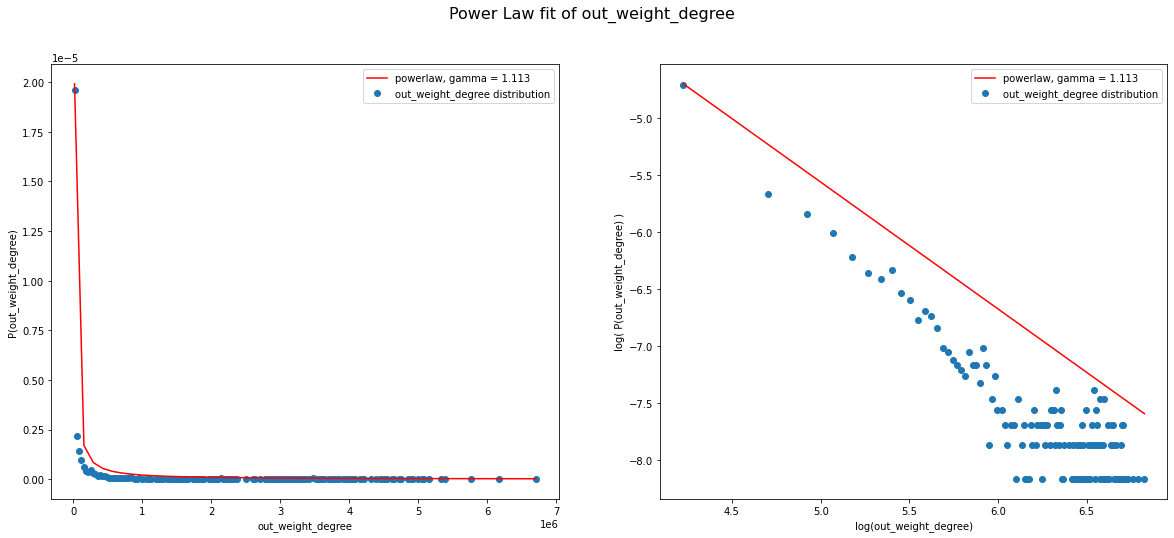

In [ ]:
g.plot_power_law(metrics_cat,"out_weight_degree")